# 参数优化器

1. 优化IC
2. 优化Ann RET
3. 优化IR

## 1_优化IC
1. 读取本地相应数据
2. 设置Optimizer()
3. 优化IC启动枚举enumerate_optimizer()
4. 获取最优结果的signal_data与performance

**1. 读取本地相应数据**

In [1]:
import numpy as np
from jaqs.data import DataView
from jaqs.research import SignalDigger
import warnings

warnings.filterwarnings("ignore")
dataview_folder = 'JAQS_Data/hs300'
dv = DataView()
dv.load_dataview(dataview_folder)

D:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Dataview loaded successfully.


In [2]:
def mask_index_member():
    df_index_member = dv.get_ts('index_member')
    mask_index_member = df_index_member ==0 #定义信号过滤条件-非指数成分
    return mask_index_member

def limit_up_down():
    # 定义可买卖条件——未停牌、未涨跌停
    trade_status = dv.get_ts('trade_status')
    mask_sus = trade_status == u'停牌'
    # 涨停
    dv.add_formula('up_limit', '(close - Delay(close, 1)) / Delay(close, 1) > 0.095', is_quarterly=False)
    # 跌停
    dv.add_formula('down_limit', '(close - Delay(close, 1)) / Delay(close, 1) < -0.095', is_quarterly=False)
    can_enter = np.logical_and(dv.get_ts('up_limit') < 1, ~mask_sus) # 未涨停未停牌
    can_exit = np.logical_and(dv.get_ts('down_limit') < 1, ~mask_sus) # 未跌停未停牌
    return can_enter,can_exit

In [3]:
mask = mask_index_member()
can_enter,can_exit = limit_up_down()
price = dv.get_ts('close_adj')
price_bench = dv.data_benchmark

Add formula failed: name [up_limit] exist. Try another name.
Add formula failed: name [down_limit] exist. Try another name.


**2.初始化Optimizer()**

In [4]:
# 优化因子
from jaqs.research import Optimizer
algorithm_opt = Optimizer(dataview=dv,
                      formula='- Correlation(vwap_adj, volume, LEN)',
                      params={"LEN":range(2,15,1)},
                      name='Cor_Vwap_Volume',
                      price=price,
                      benchmark_price=None,#=None求绝对收益 #=price_bench求相对收益
                      period=5,
                      n_quantiles=5,
                      mask=mask,
                      can_enter=can_enter,
                      can_exit=can_exit,
                      commission=0.0008,#手续费 默认0.0008
                      is_event=False,#是否是事件(0/1因子)
                      is_quarterly=False)#是否是季度因子 默认为False

**3. 枚举优化enumerate_optimizer()**

### target_type:
* ic类:
  return_ic/upside_ret_ic/downside_ret_ic
* 持有收益类
  long_ret/short_ret/long_short_ret/top_quantile_ret/bottom_quantile_ret/tmb_ret
* 收益空间类
  long_space/short_space/long_short_space/top_quantile_space/bottom_quantile_space/tmb_space

### target:
* ic类 
  "IC Mean", "IC Std.", "t-stat(IC)", "p-value(IC)", "IC Skew", "IC Kurtosis", "Ann. IR"
* 持有收益类 
  't-stat', "p-value", "skewness", "kurtosis", "Ann. Ret", "Ann. Vol", "Ann. IR", "occurance"
* 收益空间类的'upside_space_mean','upside_space_std','upside_space_mean/std','upside_space_max','upside_space_min','upside_space_percentile25','upside_space_percentile50','upside_space_percentile75','upside_space_occurance','downside_space_mean','downside_space_std','downside_space_mean/std','downside_space_max',downside_space_min','downside_space_percentile25','downside_space_percentile50','downside_space_percentile75','downside_space_occurance','up&down_space_mean_sum',　    

In [5]:
algorithm_ic_opt = algorithm_opt.enumerate_optimizer(target_type="return_ic",
                                                     target="IC Mean",
                                                     in_sample_range=[20170101,20170701],
                                                     ascending=False)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 52%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%


**4. 获取最优结果的signal_data与performance**

In [6]:
algorithm_data_opt = algorithm_opt.all_signals.get(algorithm_ic_opt[0]["signal_name"])

In [7]:
print(algorithm_data_opt.tail())

                        signal  return  quantile
trade_date symbol                               
20171222   603160.SH -0.482838     0.0         2
           603799.SH -0.741520     0.0         1
           603833.SH  0.262818     0.0         5
           603858.SH -0.375411     0.0         3
           603993.SH -0.490465     0.0         2


In [8]:
print(algorithm_ic_opt[0]["signal_name"])
print(algorithm_ic_opt[0]["ret"])
print(algorithm_ic_opt[0]["ic"])

Cor_Vwap_Volume{'LEN': 13}
             long_ret   short_ret  long_short_ret  top_quantile_ret  \
t-stat       2.501894    0.664812        1.771286          6.961844   
p-value      0.013720    0.507470        0.079090          0.000000   
skewness    -0.210919    0.413379        0.350763         -0.162317   
kurtosis    -0.322710   -0.189578        0.084759          7.356145   
Ann. Ret     0.152959    0.050741        0.099284          0.148084   
Ann. Vol     0.095461    0.119172        0.087521          0.250003   
Ann. IR      1.602325    0.425775        1.134411          0.592330   
occurance  119.000000  119.000000      119.000000       6687.000000   

           bottom_quantile_ret     tmb_ret  
t-stat               -4.380417    4.989744  
p-value               0.000010    0.000000  
skewness              1.159265    0.422506  
kurtosis             18.815342    1.235578  
Ann. Ret             -0.109962    0.259470  
Ann. Vol              0.297067    0.081195  
Ann. IR           

In [9]:
import matplotlib.pyplot as plt

def signal_obj(signal, name, period, quantile):
    price = dv.get_ts('close_adj')
    price_bench = dv.data_benchmark

    obj = SignalDigger(output_folder="hs300/%s" % name,
                       output_format='pdf')

    obj.process_signal_before_analysis(signal,
                                   price=price,
                                   n_quantiles=quantile, period=period,
                                   benchmark_price=price_bench,
                                   can_enter = can_enter,
                                   can_exit = can_exit,
                                   mask=mask
                                   )
    obj.create_full_report()
    return obj
    
def signal_plot(signal, name, period=5, quantile=5):
    obj = signal_obj(signal, name, period, quantile)
    obj.fig_objs
    plt.show()
    
def signal_data(signal, name, period=5, quantile=5):
    obj = signal_obj(signal, name, period, quantile)
    return obj.signal_data

In [10]:
dv.add_formula('Cor_Vwap_Volume','-Correlation(vwap_adj, volume, 8)', is_quarterly=False)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%


Value of signals of Different Quantiles Statistics
                min       max      mean       std  count    count %
quantile                                                           
1        -14.862705  0.374615 -0.815487  0.145372  83265  20.144579
2         -0.948111  0.688406 -0.609548  0.176436  82670  20.000629
3         -0.910831  0.816059 -0.413336  0.227705  82649  19.995548
4         -0.857445  0.906101 -0.166788  0.266489  82670  20.000629
5         -0.762486  0.995462  0.276271  0.315837  82083  19.858614
Figure saved: C:\Users\small\OneDrive\notebook\Internet_Course\4_Selection\JAQS_Plus\hs300\Cor_Vwap_Volume\returns_report.pdf
Information Analysis
                 ic
IC Mean       0.040
IC Std.       0.132
t-stat(IC)   11.396
p-value(IC)   0.000
IC Skew      -0.018
IC Kurtosis   0.502
Ann. IR       0.300
Figure saved: C:\Users\small\OneDrive\notebook\Internet_Course\4_Selection\JAQS_Plus\hs300\C

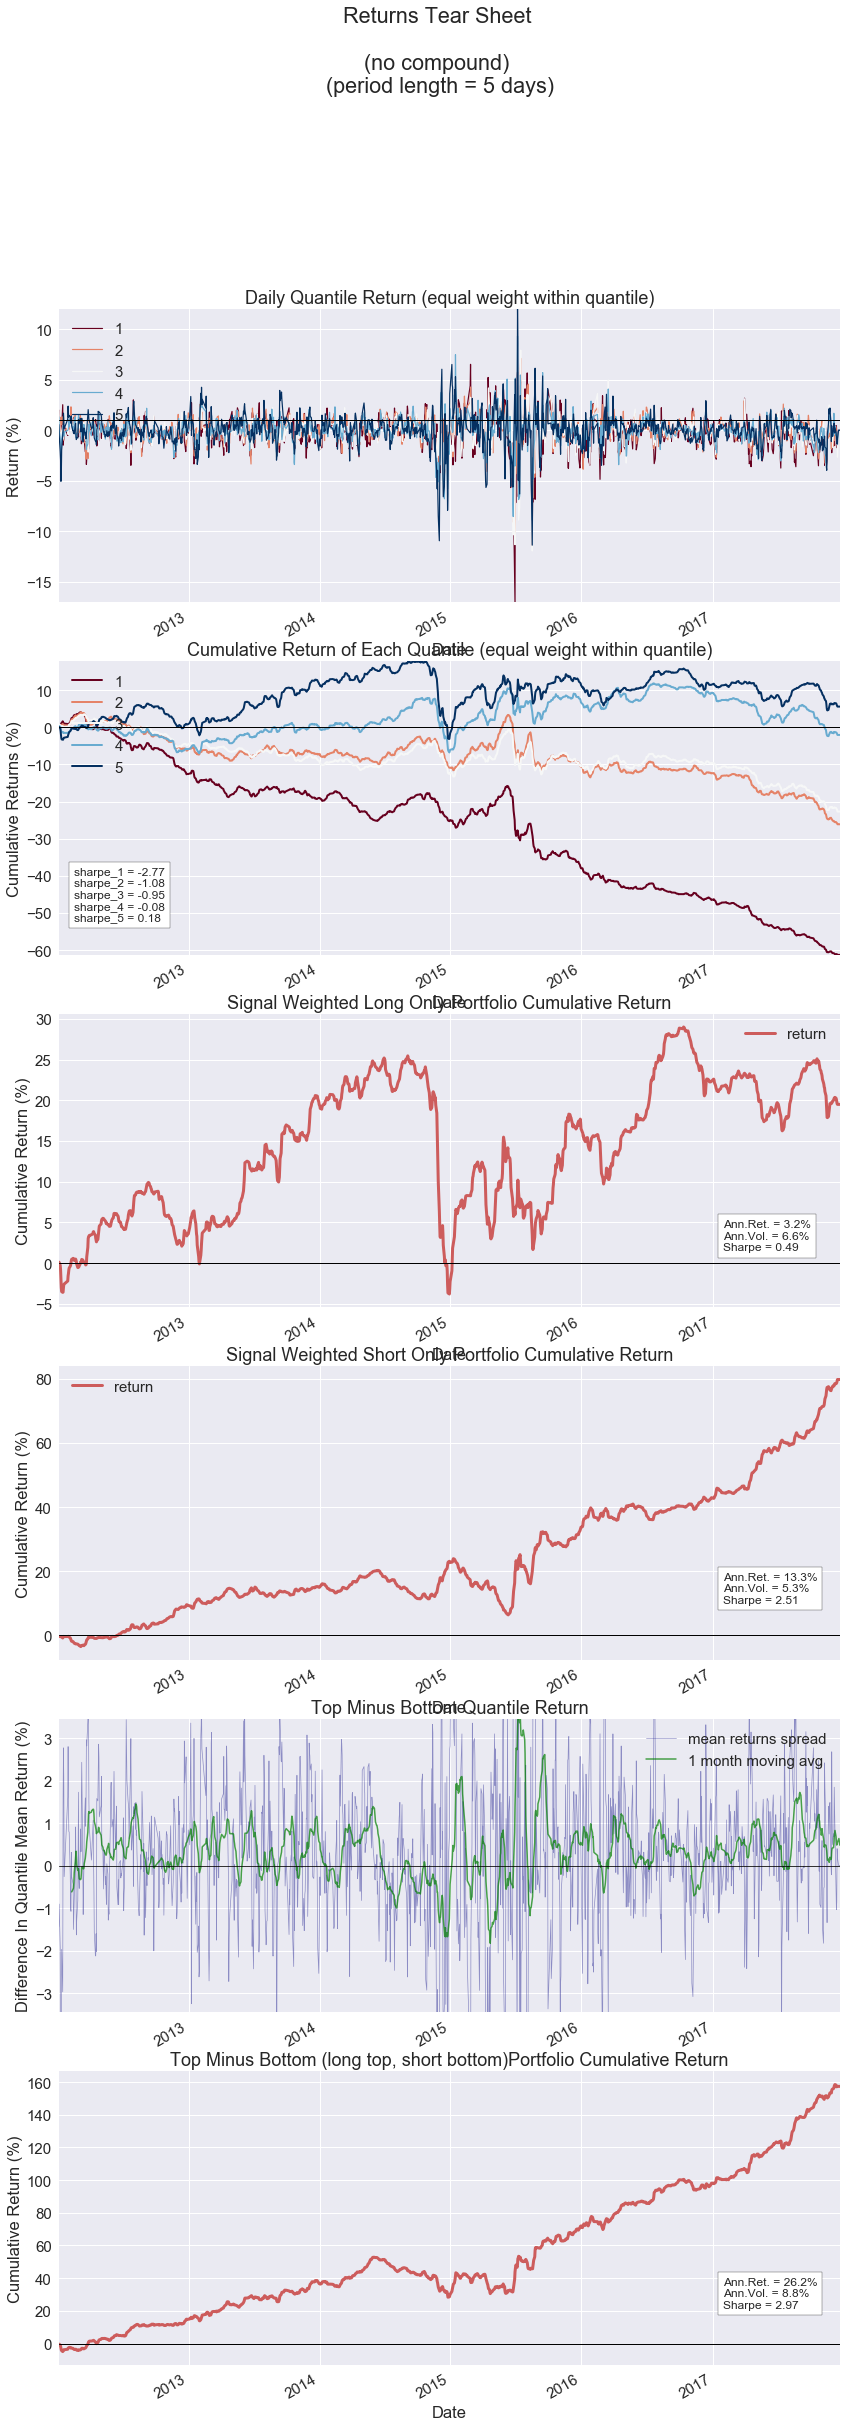

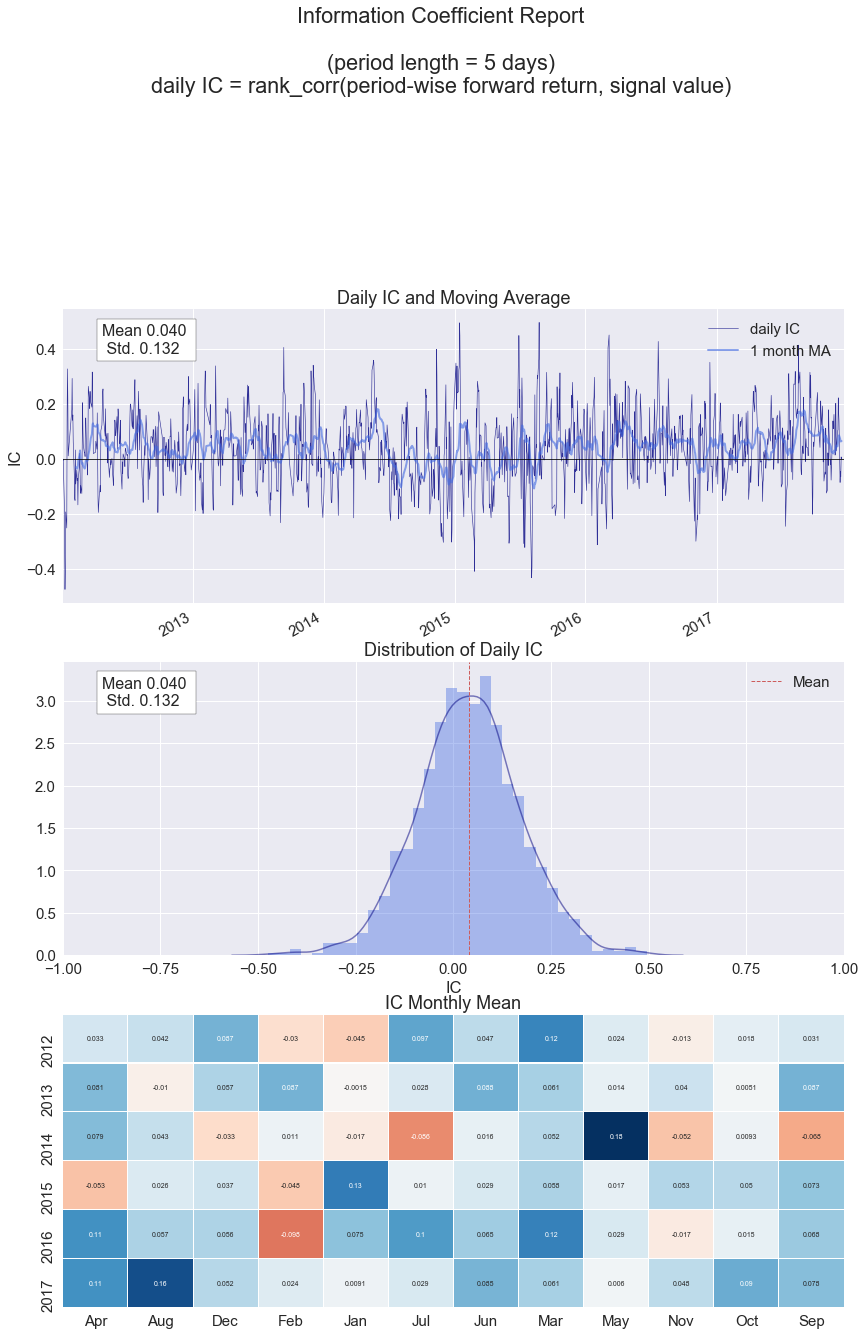

In [11]:
signal_plot(dv.get_ts('Cor_Vwap_Volume'), 'Cor_Vwap_Volume')

## 2_优化Ann. Ret
### 外部自定义算法
1. 设置Optimizer()
2. 生成字典并输入自定义算法计算出来的signal
2. 将all_signals赋值为signal字典
3. 优化Ann. Ret启动枚举enumerate_optimizer()
4. 将绩效图形化

**1. 设置Optimizer()**

**2. 生成字典并输入自定义算法计算出来的signal**

In [12]:
import pandas as pd
import talib as ta
TA_Signal = Optimizer(dataview=dv,
                      period=5,
                      n_quantiles=5,
                      mask=mask,
                      can_enter=can_enter,
                      can_exit=can_exit,
                      commission=0.0008,#手续费 默认0.0008
                      is_event=False,#是否是事件(0/1因子)
                      is_quarterly=False)#是否是季度因子 默认为False
close = dv.get_ts("close_adj")
signals_dict = {}
for param in range(2,9,1):
    slope_df = pd.DataFrame({name: -ta.LINEARREG_SLOPE(value.values, param) for name, value in close.iteritems()}, index=close.index)
    slope_df.columns.name='symbol'
    dv.append_df(slope_df,'SLOPE_PARAM='+str(param))
    signals_dict['SLOPE_PARAM='+str(param)] = TA_Signal.cal_signal(dv.get_ts('SLOPE_PARAM='+str(param)))

Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%


**3. 将all_signals赋值为signal字典 **

In [13]:
TA_Signal.all_signals = signals_dict

**4. 优化Ann. Ret启动枚举enumerate_optimizer()**

In [24]:
ret_best = TA_Signal.enumerate_optimizer(target_type="long_ret",#优化目标类型
                                         target = "Ann. Ret",
                                         in_sample_range=None,
                                         ascending=False)

In [31]:
print(ret_best[0]["signal_name"],',',ret_best[0]["ret"].loc['Ann. Ret', 'long_ret'])
print(ret_best[1]["signal_name"],',',ret_best[1]["ret"].loc['Ann. Ret', 'long_ret'])

SLOPE_PARAM=6 , 0.0592788850637
SLOPE_PARAM=7 , 0.0526284491294


Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%


Value of signals of Different Quantiles Statistics
                min        max      mean       std  count    count %
quantile                                                            
1        -27.756178   0.636693 -0.531595  0.945832  82996  20.143487
2         -1.979614   1.055930 -0.074165  0.162311  82402  19.999320
3         -0.906883   1.688512  0.006881  0.137509  82395  19.997621
4         -0.527076   3.048853  0.083919  0.205871  82402  19.999320
5         -0.304564  31.619752  0.469493  0.961335  81829  19.860251
Figure saved: C:\Users\small\OneDrive\notebook\Internet_Course\4_Selection\JAQS_Plus\hs300\slope_opt\returns_report.pdf
Information Analysis
                 ic
IC Mean       0.052
IC Std.       0.168
t-stat(IC)   11.706
p-value(IC)   0.000
IC Skew      -0.047
IC Kurtosis   0.088
Ann. IR       0.308
Figure saved: C:\Users\small\OneDrive\notebook\Internet_Course\4_Selection\JAQS_Plus\hs300\

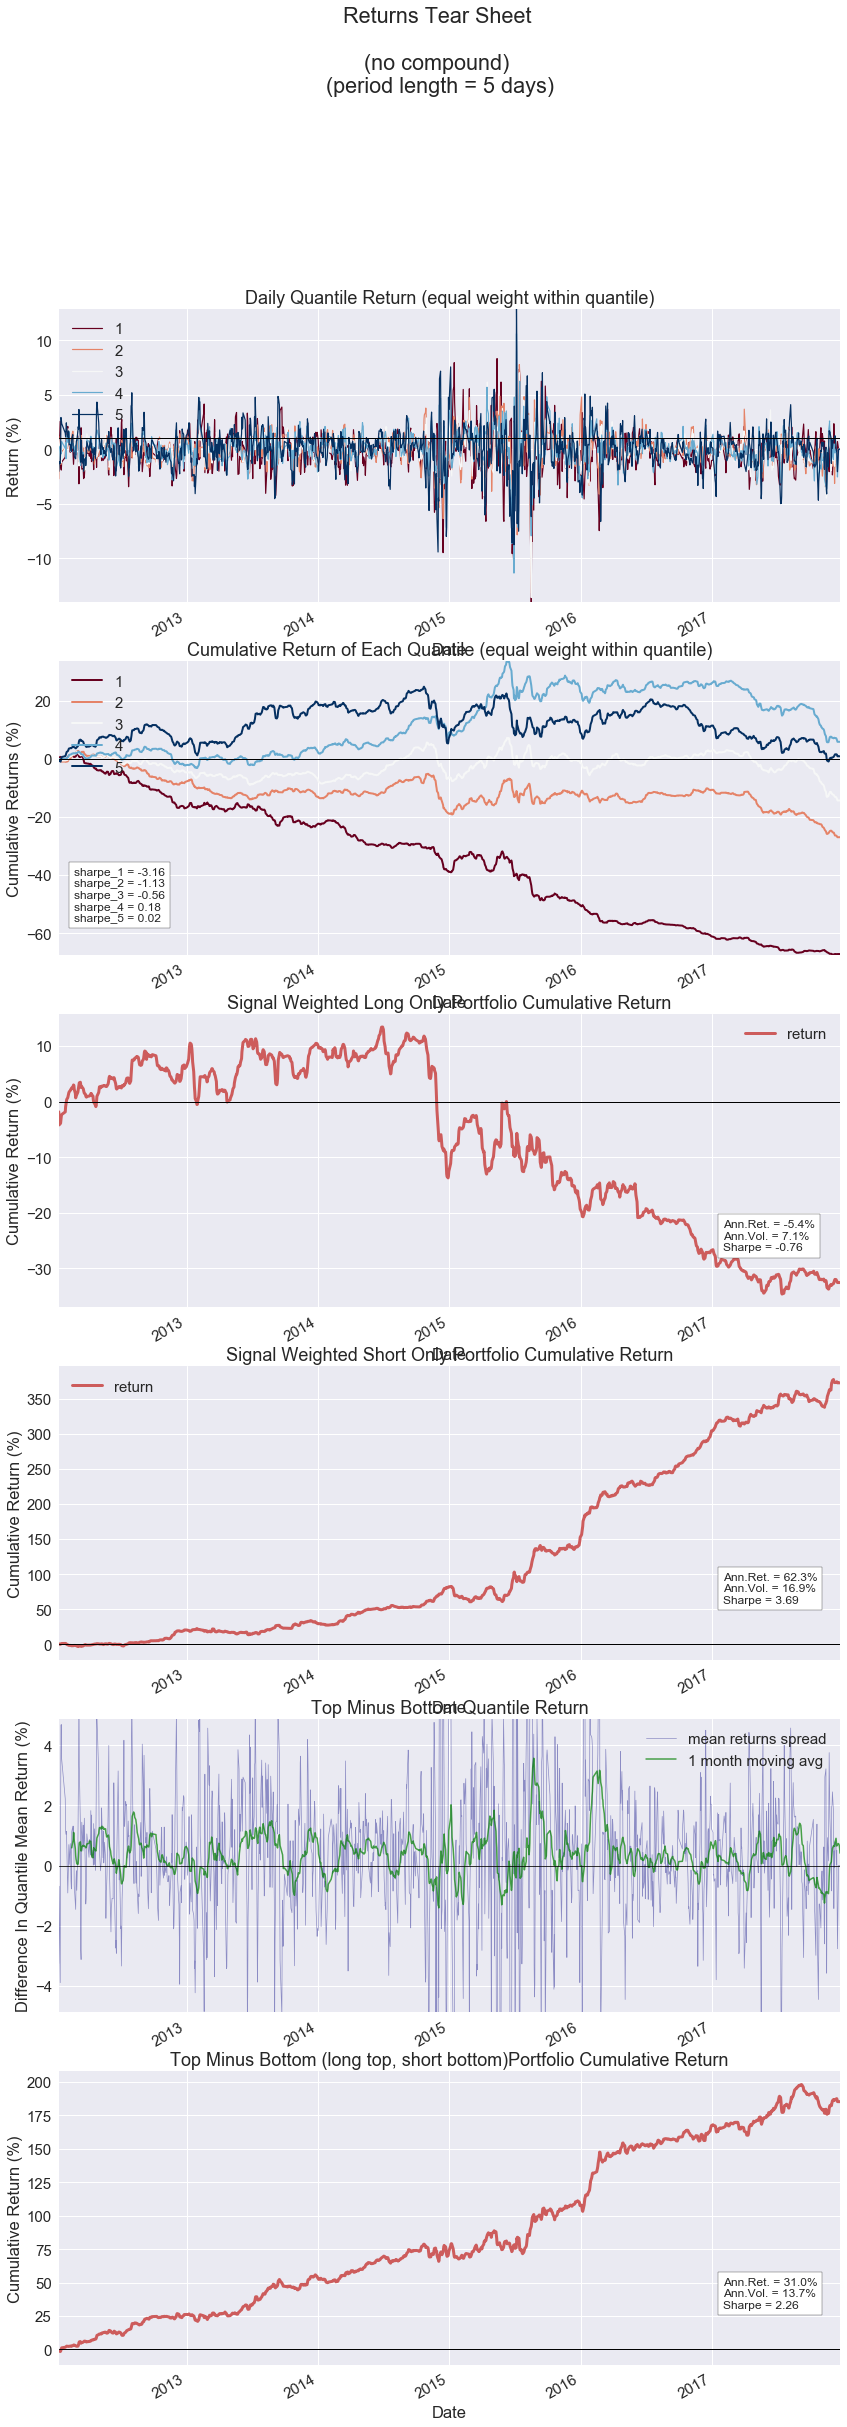

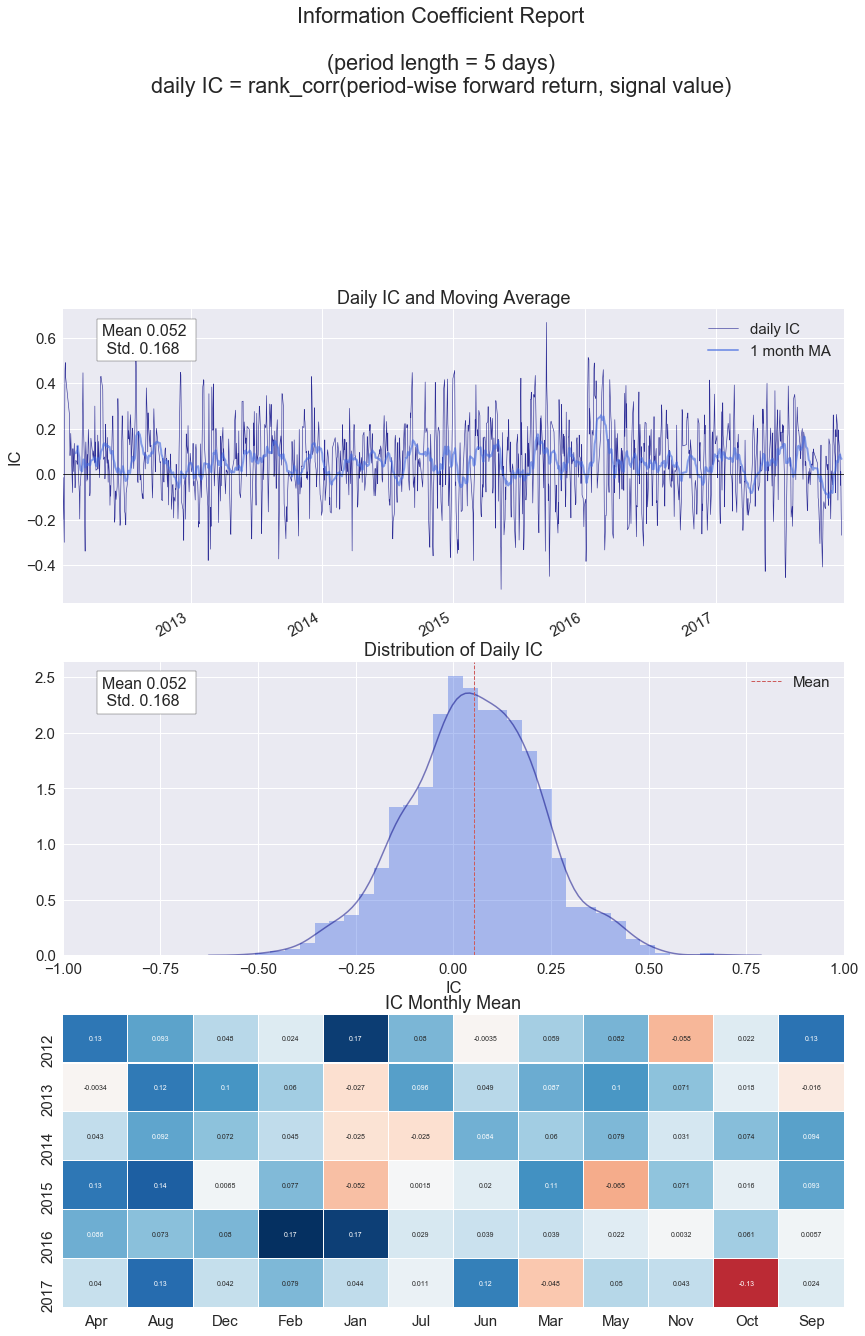

In [26]:
signal_plot(dv.get_ts(ret_best[0]["signal_name"]), 'slope_opt')

## 3_优化Ann. IR
### 均线事件驱动
1. 设置事件驱动的Optimizer
2. 优化Ann. IR启动枚举enumerate_optimizer()
3. 将绩效图形化

**1. 设置事件驱动的Optimizer**

In [17]:
event_opt = Optimizer(dataview=dv,
                      formula='(Ts_Mean(close_adj, SHORT)>=Ts_Mean(close_adj, LONG))&&(Delay(Ts_Mean(close_adj, SHORT)<Ts_Mean(close_adj, LONG), DELAY))',
                      params={'SHORT':range(2,6,1),'LONG':range(30,50,5),'DELAY':range(1,3,1)},
                      name='Cross',
                      price=price,
                      benchmark_price=None,#=None求绝对收益 #=price_bench求相对收益
                      period=5,
                      n_quantiles=5,
                      mask=mask,
                      can_enter=can_enter,
                      can_exit=can_exit,
                      commission=0.0008,#手续费 默认0.0008
                      is_event=True,#是否是事件(0/1因子)
                      is_quarterly=False)#是否是季度因子 默认为False

**2. 优化IR启动枚举enumerate_optimizer()**

In [18]:
ir_best = event_opt.enumerate_optimizer(target_type="long_ret",
                                        target="Ann. IR",
                                        in_sample_range=[20160105,20170701],
                                        ascending=False)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 52%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective da

**3. 将绩效图形化**

In [19]:
print(ir_best[0]["signal_name"])
print(ir_best[0]["ret"])

Cross{'SHORT': 5, 'LONG': 45, 'DELAY': 2}
              long_ret  long_short_ret
t-stat        4.320175        0.001870
p-value       0.000020        0.998510
skewness      1.066033       -0.697733
kurtosis      8.095972        6.272898
Ann. Ret      0.146586        0.000174
Ann. Vol      0.295865        0.243576
Ann. IR       0.495450        0.000714
occurance  3681.000000      333.000000


In [20]:
import matplotlib.pyplot as plt


def event_obj(signal, name, period):
    price = dv.get_ts('close_adj').loc[20160105:]
#     price_bench = dv.data_benchmark.loc[20160105:]

    # Step.4 analyze!
    obj = SignalDigger()
    
    df_all, df_events, df_stats = obj.create_binary_event_report(signal.loc[20160105:], price, mask.loc[20160105:], can_enter.loc[20160105:], can_exit.loc[20160105:],periods=[period,period*2, period*3])
    res = obj.create_full_report()
    
    print(df_stats)
    return obj
    
def event_plot(signal, name, period=5):
    obj = event_obj(signal, name, period)
    obj.fig_objs
    plt.show()
    
def event_data(signal, name, period=5):
    obj = event_obj(signal, name, period)
    return obj.signal_data

In [21]:
event_data_opt = event_opt.all_signals.get(ir_best[0]["signal_name"])

In [22]:
dv.add_formula('Cross','(Ts_Mean(close_adj,5)>=Ts_Mean(close_adj,45))&&(Delay(Ts_Mean(close_adj, 5)<Ts_Mean(close_adj,45),2))', is_quarterly=False)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%

       Calendar Distribution    (8329 occurance from 2016-01-05 to 2017-12-22):
Figure saved: C:\Users\small\OneDrive\notebook\Internet_Course\4_Selection\JAQS_Plus\event_report.pdf


Value of signals of Different Quantiles Statistics
          min  max      mean       std   count  count %
quantile                                               
1         0.0  1.0  0.034396  0.182245  136469    100.0
Figure saved: C:\Users\small\OneDrive\notebook\Internet_Course\4_Selection\JAQS_Plus\returns_report.pdf
Information Analysis
                ic
IC Mean      0.002
IC Std.      0.073
t-stat(IC)   0.447
p-value(IC)  0.655
IC Skew     -0.261
IC Kurtosis  0.030
Ann. IR      0.021
Figure saved: C:\Users\small\OneDrive\notebook\Internet_Course\4_Selection\JAQS_Plus\information_report

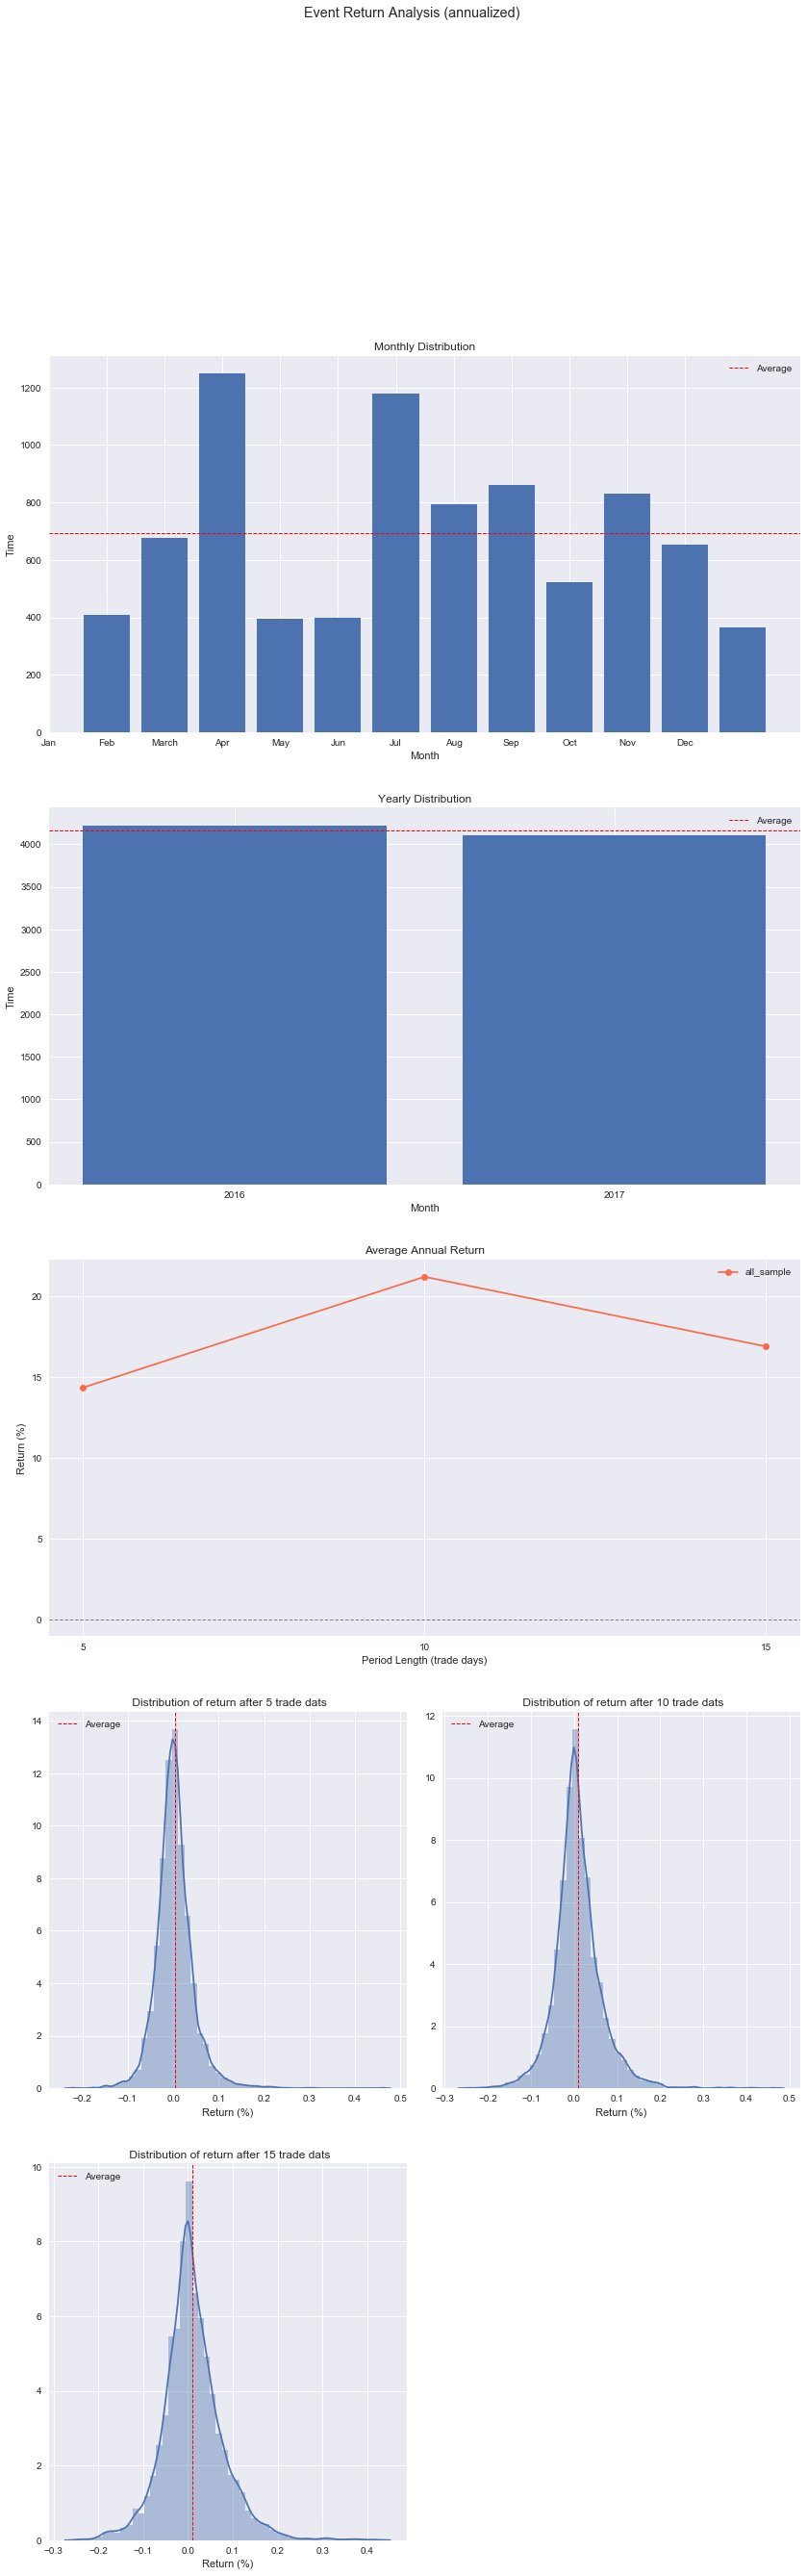

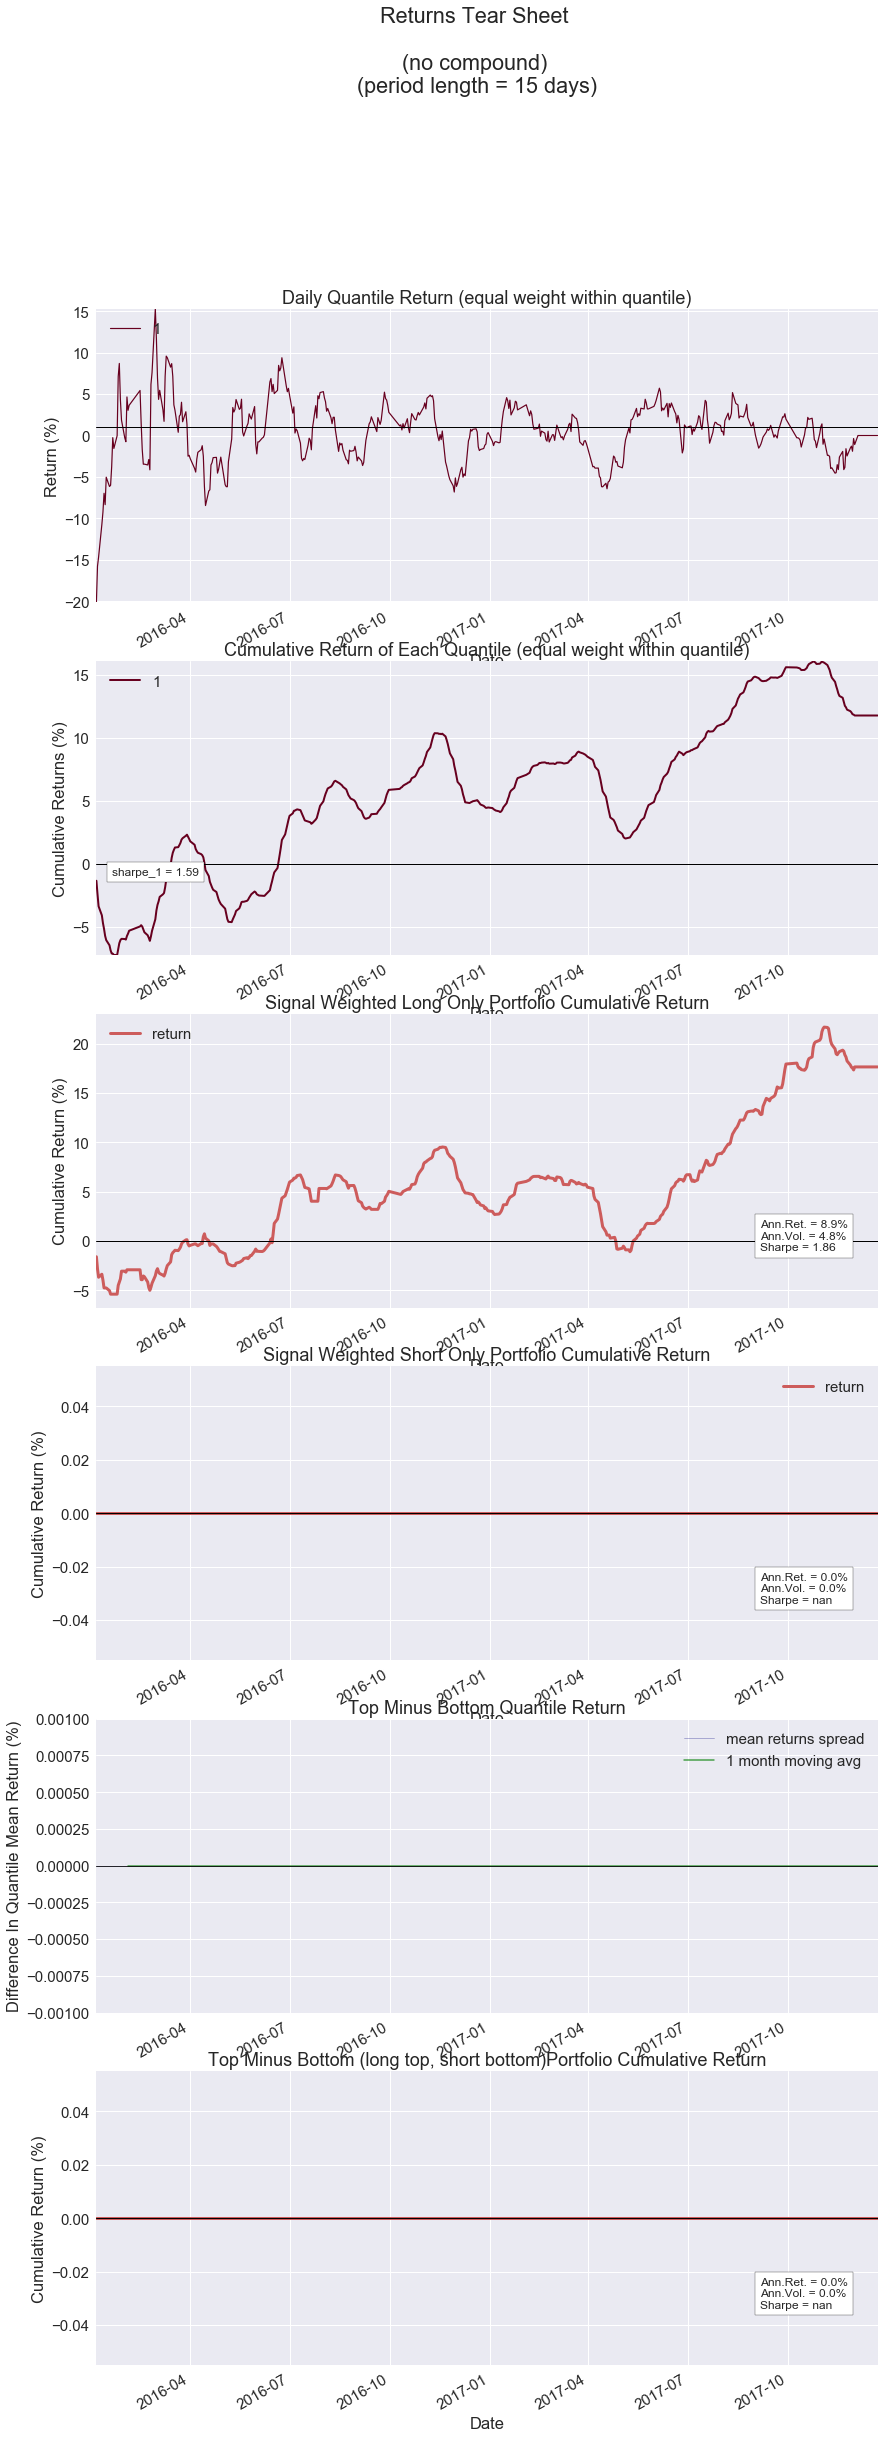

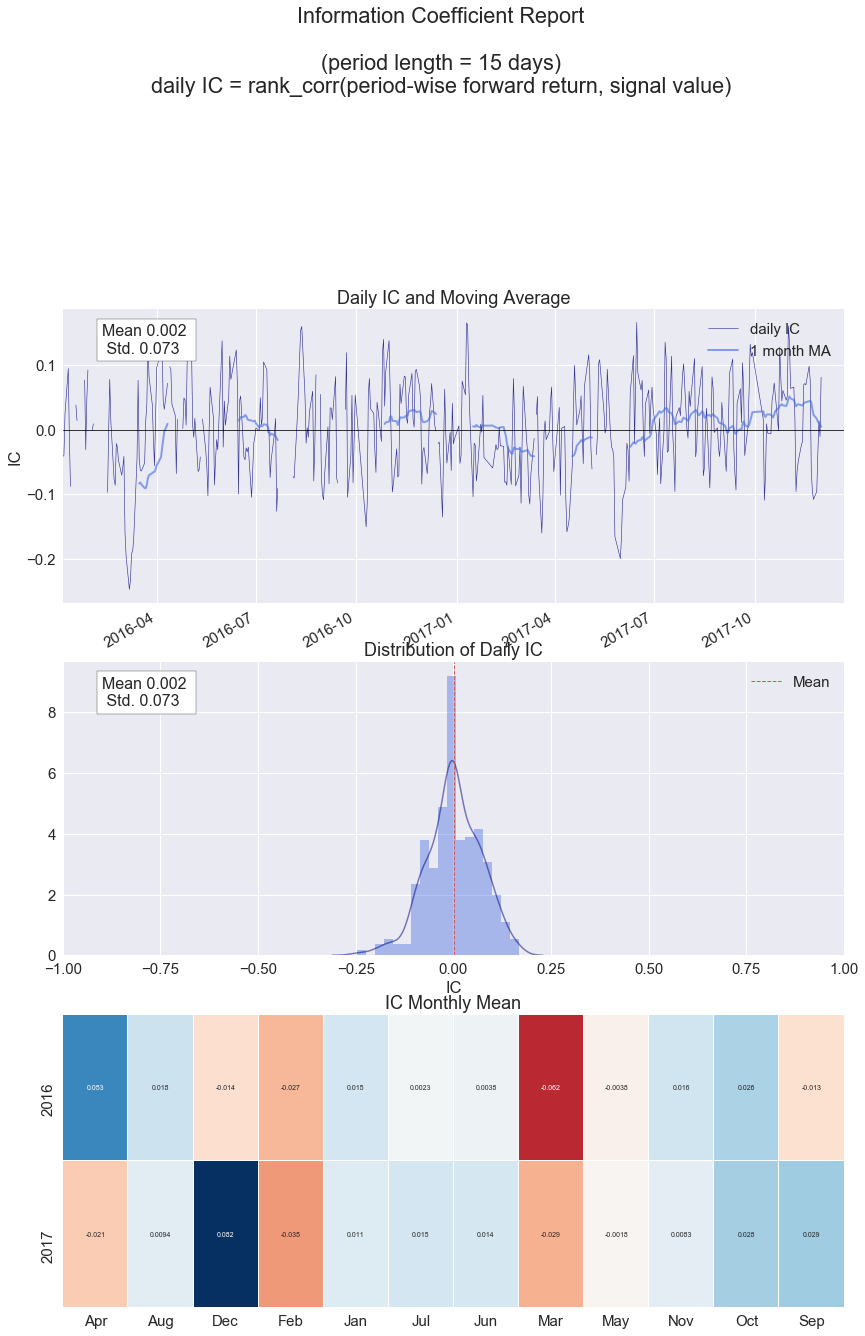

In [23]:
event_plot(dv.get_ts('Cross'),'Cross')